In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv"
df = pd.read_csv(data_path, delimiter=',')

fuel_types = df['fuel_type'].unique()
# Small epsilon to avoid division by zero
epsilon = 1e-6

# Create new ratio features
df['vm_fc_ratio'] = df['vm'] / (df['fc'] + epsilon)
df['ac_fc_ratio'] = df['ac'] / (df['fc'] + epsilon)
min_vm_fc_ratio = df['vm_fc_ratio'].min()
max_ac_fc_ratio = df['ac_fc_ratio'].max()
min_ac_fc_ratio = df['ac_fc_ratio'].min()
max_vm_fc_ratio = df['vm_fc_ratio'].max()

# Update feature list
feature_cols = [
    'h', 'wc', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'temperature', 'residence_time', 'pressure', 'heat_rate',
    'vm_fc_ratio', 'ac_fc_ratio'
]

# Also update min-max bounds accordingly (you may compute new ranges empirically or just fit on full data)


# These are your original min and max values (as from your summary)
min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10, 'vm_fc_ratio': min_vm_fc_ratio, 'ac_fc_ratio': min_ac_fc_ratio
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402, 'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000, 'vm_fc_ratio':max_vm_fc_ratio, 'ac_fc_ratio': max_ac_fc_ratio}

# Optional: define a margin (e.g. 10%)
margin_ratio = 0.4

# Create expanded bounds
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = min_val - range_val * margin_ratio
    if new_min < 0:
        new_min = 0
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

# Prepare fake data to fit the scaler
X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})

# Fit a global scaler based on the expanded bounds
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# Store results
results = []

# Iterate over each fuel type
for test_fuel in fuel_types:
    print(f"Processing fuel type: {test_fuel}")

    # Train-test split
    train_data = df[df['fuel_type'] != test_fuel].drop(columns=['fuel_type']).reset_index(drop=True)
    test_data = df[df['fuel_type'] == test_fuel].drop(columns=['fuel_type']).reset_index(drop=True)

    X_train = train_data.drop(columns=['sample', 'devol_yield'])
    y_train = train_data['devol_yield']
    X_test = test_data.drop(columns=['sample', 'devol_yield'])
    y_test = test_data['devol_yield']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).drop(['vm','c','h', 'wc', 'fc', 'ac'], axis=1)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).drop(['vm','c','h', 'wc', 'fc', 'ac'], axis=1)


    # Define base MLP model
    mlp = MLPRegressor(max_iter=2000, random_state=42)

    # Define hyperparameter space
    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64, 32)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }

    # Randomized Search with 5-fold cross-validationa
    random_search = RandomizedSearchCV(
        estimator=mlp,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42,
        scoring='r2'
    )

    # Fit model
    random_search.fit(X_train_scaled, y_train)

    # Best model
    best_mlp = random_search.best_estimator_
    print("\nBest Parameters Found:", random_search.best_params_)

    # Evaluate on cellulose test set
    y_pred = best_mlp.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({
        "Fuel Type": test_fuel,
        "R Squared": r2,
        "RMSE": rmse,
        "MAE": mae
    })
print(results)
print("\nModel and preprocessing pipeline saved.")


Processing fuel type: Cellulose
Fitting 5 folds for each of 20 candidates, totalling 100 fits



KeyboardInterrupt



In [45]:
test_data

,Unnamed: 0,sample,wc,vm,fc,ac,c,h,o,n,...,hc,oc,lhv,temperature,residence_time,pressure,heat_rate,fuel_type,fuel_category,devol_yield
360,2118,TW_168,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,400,10.0,1.0,1000,torrwash,biomass,35.076109
361,2132,TW_185,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,400,10.0,1.0,1000,torrwash,biomass,36.186770
362,2134,TW_187,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,400,10.0,1.0,1000,torrwash,biomass,30.050251
363,2204,TW_262,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,400,10.0,1.0,1000,torrwash,biomass,25.854430
364,2199,TW_257,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,0.5,1.0,1000,torrwash,biomass,38.954955
365,2201,TW_259,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,0.5,1.0,1000,torrwash,biomass,32.356058
366,2213,TW_271,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,0.5,1.0,1000,torrwash,biomass,28.155668
367,2216,TW_274,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,0.5,1.0,1000,torrwash,biomass,27.745467
368,2226,TW_284,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,0.5,1.0,1000,torrwash,biomass,40.506768
369,2198,TW_256,4.72,68.66,24.29,7.06,58.16,4.91,27.9,0.32,...,1.0,0.4,19.0,600,1.0,1.0,1000,torrwash,biomass,31.346499


Text(0, 0.5, 'Predicted devol_yield')

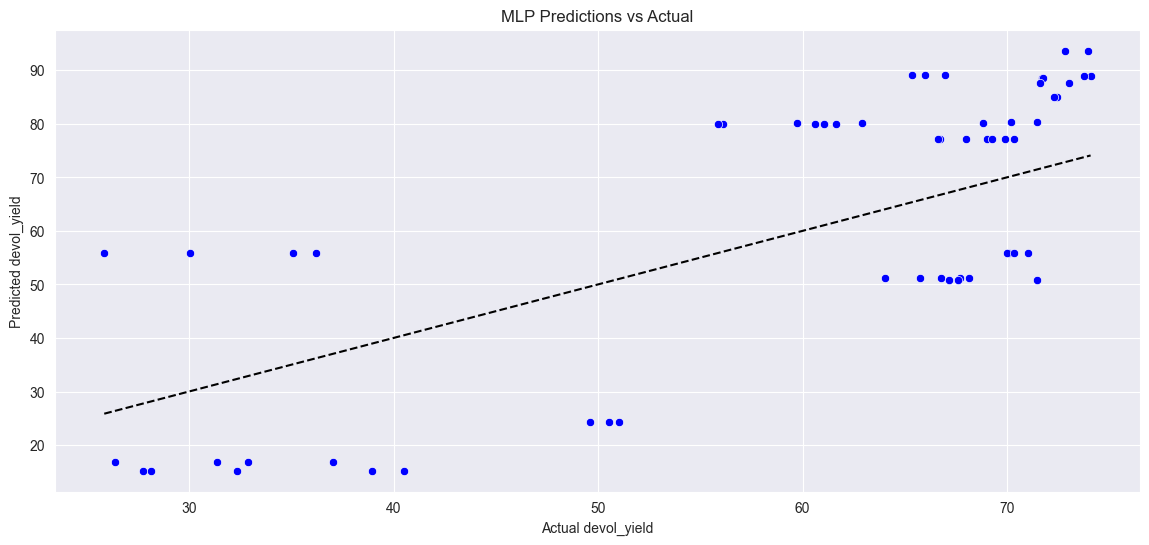

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("MLP Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

(array([ 5.,  9.,  9.,  1.,  0.,  1., 11.,  8., 13.,  2.]),
 array([-26.77998868, -21.10890875, -15.43782882,  -9.76674889,
         -4.09566897,   1.57541096,   7.24649089,  12.91757082,
         18.58865075,  24.25973068,  29.93081061]),
 <BarContainer object of 10 artists>)

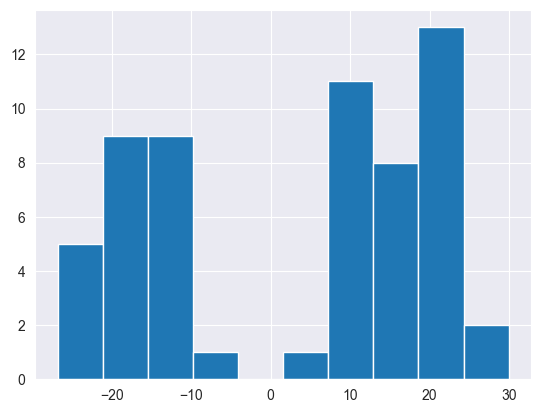

In [47]:
plt.hist(y_pred-y_test)

In [48]:
test_data.shape

(59, 22)